# GRFs

## Generating the fields

In [2]:
physical = False
N = 64
A, B = 1., 2.
theta = [A, B]
deltaA, deltaB = 0.01, 0.01
delta_theta = tf.constant([deltaA, deltaB])

def simulate(thet, n_sims, seed = None):
    a, b = thet
    if(seed != None) : np.random.seed(seed)
    seeds = np.random.randint(1e7, size = (n_sims))
    lis = []
    for i in range(n_sims):
        pb = pbox.PowerBox(
            N=N,                     # Number of grid-points in the box
            dim=2,                     # 2D box
            pk = lambda k: a*k**(-b), # The power-spectrum
            boxlength = N,           # Size of the box (sets the units of k in pk)
            vol_normalised_power=True, 
            ensure_physical = physical,
            seed = seeds[i]
        )
        lis.append(pb.delta_x())
    return np.array(lis)

In [3]:
n_s = 4000; n_d = 4000; dim_list = [0, 1]; seed = np.random.randint(1e4); 
print("seed = ", seed)
thetaLis = [[A + deltaA, B], [A, B + deltaB]] 

ptsCov = simulate(theta, n_s)
pts = simulate(theta, n_d, seed = seed)
pts_pert = [simulate(thet, n_d, seed) for thet in thetaLis]
all_pts = [ptsCov, pts, *pts_pert]

seed =  6597


## Filtration 

In [5]:
all_st = []; 
for ptclouds in all_pts:
    st_list = [findCC(sim) for sim in tqdm(ptclouds)]
    all_st.append(st_list)

100%|██████████| 4000/4000 [00:31<00:00, 126.57it/s]


## Vectorization

### TopK Binned

In [8]:
veclayer = TopKBinned(topks = [280, 450], num_bins = [10, 15])
all_vecs = []; 
for st_list in all_st:
    vecs = [veclayer(item) for item in st_list]
    all_vecs.append(vecs)
all_vecs_binned = np.array(all_vecs)

Decrease topk  449
Decrease topk  277
Decrease topk  442
Decrease topk  447
Decrease topk  447
Decrease topk  446


### TopK sorted

In [9]:
veclayer = TopKBD(topks = [280, 450])
all_vecs = []; 
for st_list in all_st:
    vecs = [veclayer(item) for item in st_list]
    all_vecs.append(vecs)
all_vecs_bd = np.array(all_vecs)

Decrease topk  449
Decrease topk  277
Decrease topk  442
Decrease topk  447
Decrease topk  447
Decrease topk  446


## Fisher Analysis

### Thoeretical FI

In [10]:
def fisher(θ, k, N):
    A, B = θ
    k = k[0:N//2, 0:N].flatten()
    Pk = A*k**(-B)

    Cinv = np.diag(1. / Pk)
    C_A =  np.diag(k ** -B)
    C_B =  np.diag(- Pk * np.log(k))

    F_AA = 0.5 * np.trace((C_A @ Cinv @ C_A @ Cinv))
    F_AB = 0.5 * np.trace((C_A @ Cinv @ C_B @ Cinv))
    F_BA = 0.5 * np.trace((C_B @ Cinv @ C_A @ Cinv))
    F_BB = 0.5 * np.trace((C_B @ Cinv @ C_B @ Cinv))

    return np.array([[F_AA, F_AB], [F_BA, F_BB]])

pb = pbox.PowerBox(
    N = N,                     # Number of grid-points in the box
    dim = 2,                     # 2D box
    pk = lambda k: A*k**(-B), # The power-spectrum
    boxlength = N,           # Size of the box (sets the units of k in pk)
    vol_normalised_power=True, 
    ensure_physical = physical,
)

TFM = fisher(theta, pb.k(), N)

### Fisher Matrix calculation - binned + MOPED

In [11]:
fish = fisherMOPED(all_vecs_binned, delta_theta)
fisherMatrix = fish.FM.numpy()
print("The fisher matrix for this pipeline is ", fish.FMnp)
print("The theoretical fisher matrix is ", np.round(TFM.flatten()))

print("\nThe fisher information using MOPED is ", np.log(np.linalg.det(fisherMatrix)))
print("The theoretical fisher information is ",  np.log(np.linalg.det(TFM)))

The fisher matrix for this pipeline is  [ 405.94 -301.92 -301.92  378.58]
The theoretical fisher matrix is  [1024. -813. -813.  897.]

The fisher information using MOPED is  11.043363335831035
The theoretical fisher information is  12.456434007823539


### Fisher Matrix from sorted bd + compressing using neural networks 

In [39]:
inp_vecs = all_vecs_bd
div = (np.array([0.6,  0.2, 0.2]) * inp_vecs.shape[1]).astype(int)
div = np.cumsum(div)
train_vecs, valid_vecs, test_vecs = inp_vecs[:, :div[0]], inp_vecs[:, div[0]:div[1]], inp_vecs[:, div[1]:div[2]]

hidden_sz = inp_vecs.shape[-1]//2
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_sz, activation = tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(2)])

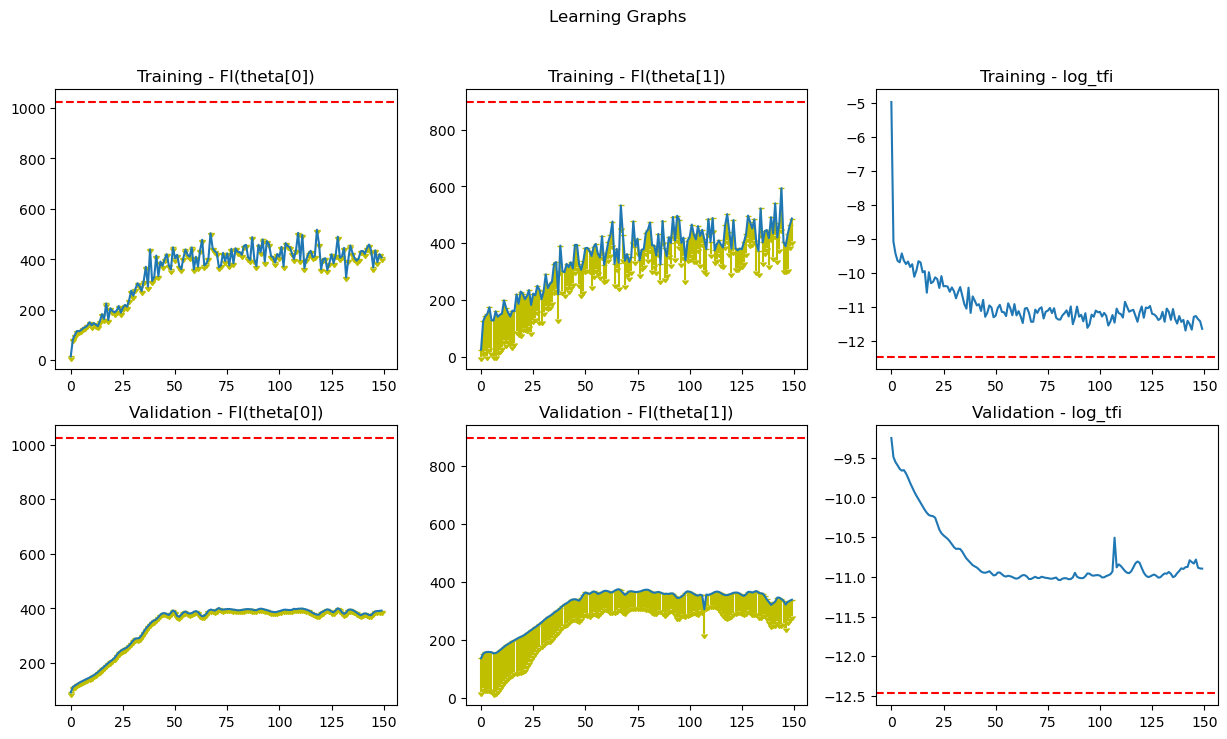

Best Valid FM =  [ 392.68 -287.21 -287.21  368.99] 0.48 62.48 11.04143
Test FM =  [ 422.73 -325.45 -325.45  405.4 ] 0.52 53.72 11.089169


In [41]:
comp_final = trainAndValidate(delta_theta, train_vecs, valid_vecs, test_vecs, comp, TFM, num_epochs = 150, batch_size = 256)

In [42]:
tf.__version__

'2.10.0'